In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from brancharchitect.io import read_newick
from brancharchitect.distances.plotting.matrix_plots import plot_distance_matrix
from brancharchitect.distances.plotting.scatter_plots import plot_component_umap_3d
from brancharchitect.distances.analysis.dimensionality import perform_umap
from brancharchitect.distances.analysis.clustering import perform_clustering
from brancharchitect.distances.distances import compute_pairwise_pivot_edge_paths, calculate_normalised_matrix
from typing import List
from brancharchitect.tree import Node

import numpy as np
from numpy import ndarray
from typing import Any
from numpy import dtype
from numpy._typing import _64Bit
from numpy import signedinteger


In [2]:
trees: List[Node] = read_newick(
    "/Users/berksakalli/Projects/BranchArchitect/notebooks/data/alltrees_treees_cutted/alltrees.trees_cutted.newick"
)
weighted = True

In [3]:
results = compute_pairwise_pivot_edge_paths(trees=trees)

100%|██████████| 27495/27495 [00:08<00:00, 3210.69it/s]


/Users/berksakalli/Projects/BranchArchitect/.venv/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning:

using precomputed metric; inverse_transform will be unavailable

/Users/berksakalli/Projects/BranchArchitect/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



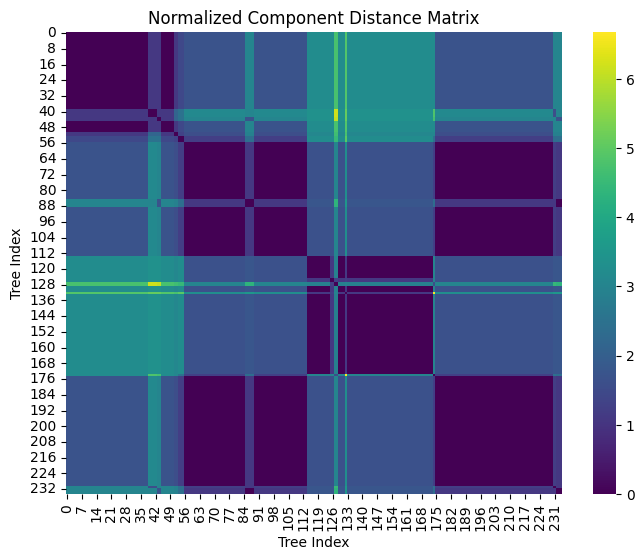

In [6]:
import umap

normalized_matrix = []
normalized_matrix = calculate_normalised_matrix(results, len(trees))

# 4. Visualize the normalized distance matrix
fig, ax = plt.subplots(figsize=(8, 6))
plot_distance_matrix(
    normalized_matrix, ax=ax, title="Normalized Component Distance Matrix"
)

# Perform clustering
cluster_labels: ndarray[Any, dtype[signedinteger[_64Bit]]] = perform_clustering(normalized_matrix, n_clusters=5)

# Get UMAP embedding - consolidated into single approach
umap_model = umap.UMAP(
    n_components=3,
    metric="precomputed",
    random_state=42,
)

embedding = umap_model.fit_transform(normalized_matrix)

# Plot with graph structure
plot_component_umap_3d(
    embedding=embedding,
    cluster_labels=cluster_labels,
    title="UMAP Embedding with Graph Structure",
    show_graph=True,  # Set to False if you want to hide the graph
    # graph_opacity=0.10,  # Adjust this value: 0.0 (invisible) to 1.0 (fully opaque)
)

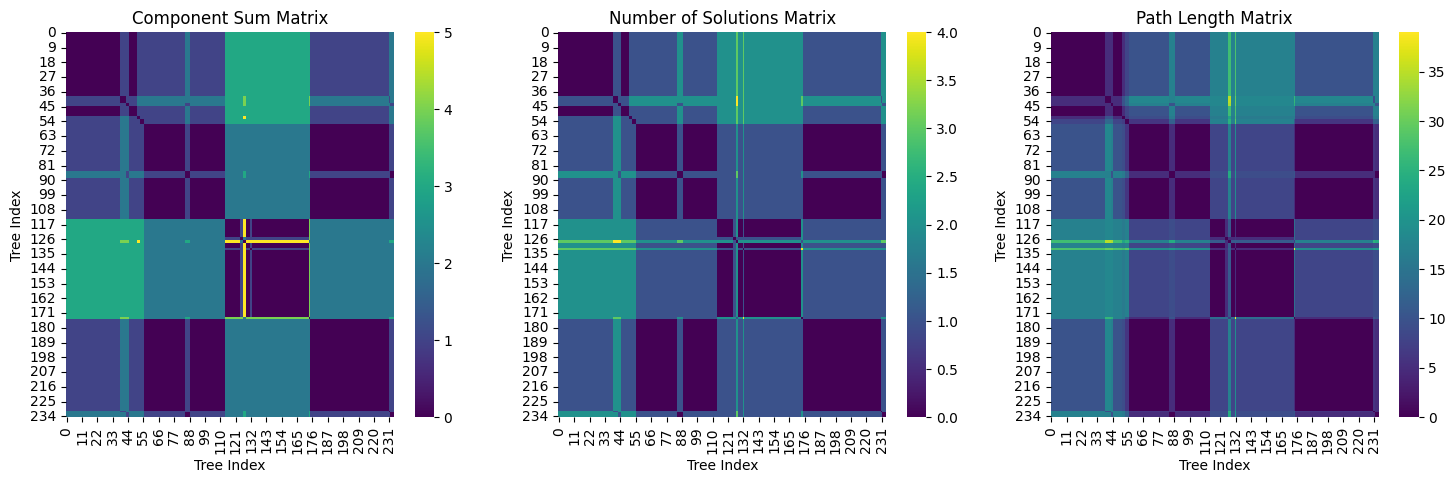

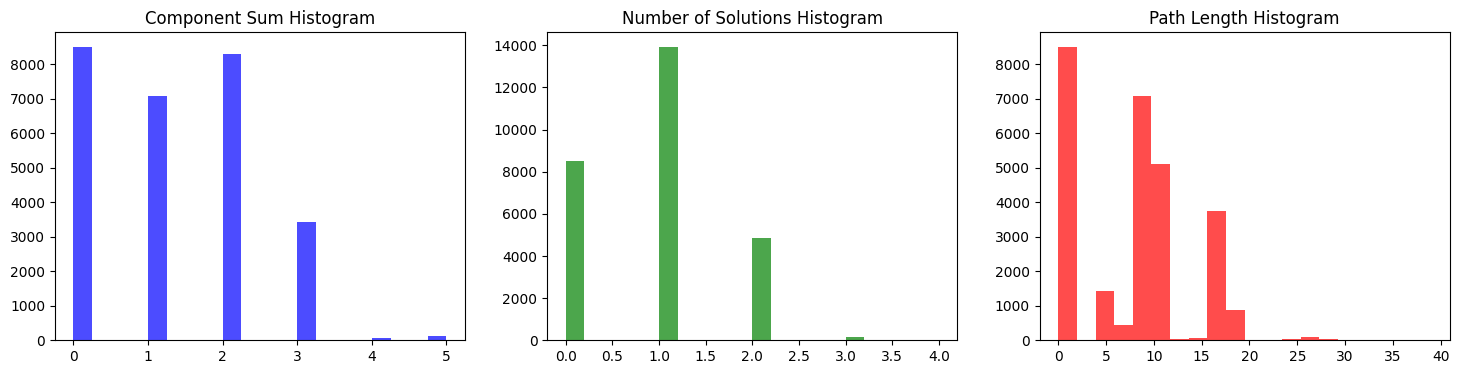

/Users/berksakalli/Projects/BranchArchitect/.venv/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning:

using precomputed metric; inverse_transform will be unavailable

/Users/berksakalli/Projects/BranchArchitect/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [5]:
# --- Diagnostic Visualization of Distance Components ---
# Extract and plot each component matrix and their histograms
tree_dimensions: int = len(trees)
component_sum_matrix = np.zeros((tree_dimensions, tree_dimensions), dtype=float)
num_solutions_matrix = np.zeros((tree_dimensions, tree_dimensions), dtype=float)
path_length_matrix = np.zeros((tree_dimensions, tree_dimensions), dtype=float)

for i, j, components, s_edges, paths_i, paths_j in results:
    component_sum: int = sum(len(c) for c in components)
    num_solutions: int = len(components)
    path_length: int = sum(len(pi) + len(pj) for pi, pj in zip(paths_i, paths_j))
    component_sum_matrix[i, j] = component_sum
    component_sum_matrix[j, i] = component_sum
    num_solutions_matrix[i, j] = num_solutions
    num_solutions_matrix[j, i] = num_solutions
    path_length_matrix[i, j] = path_length
    path_length_matrix[j, i] = path_length

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
plot_distance_matrix(component_sum_matrix, ax=axs[0], title="Component Sum Matrix")
plot_distance_matrix(num_solutions_matrix, ax=axs[1], title="Number of Solutions Matrix")
plot_distance_matrix(path_length_matrix, ax=axs[2], title="Path Length Matrix")
plt.show()

# Plot histograms
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
axs[0].hist(component_sum_matrix[np.triu_indices(tree_dimensions, 1)], bins=20, color='b', alpha=0.7)
axs[0].set_title('Component Sum Histogram')
axs[1].hist(num_solutions_matrix[np.triu_indices(tree_dimensions, 1)], bins=20, color='g', alpha=0.7)
axs[1].set_title('Number of Solutions Histogram')
axs[2].hist(path_length_matrix[np.triu_indices(tree_dimensions, 1)], bins=20, color='r', alpha=0.7)
axs[2].set_title('Path Length Histogram')
plt.show()

embedding = perform_umap(path_length_matrix)

plot_component_umap_3d(
  embedding, cluster_labels, title="UMAP Embedding (Component Distance)"
)

### Next Steps

- If the path length only metric gives better separation, consider using it as your main tree distance for this dataset.
- Optionally, try a weighted sum where path length has a much higher weight than the other components.
- You can also compute the correlation between the path length only matrix and the RF matrix to quantify their similarity.

If you want to proceed with these analyses, let me know!